# Welcome to Learning Enabled Optimization(LEO) Software

## What does this software do?

The goal of this software is to allow users to create **statistical learning (SL)** models from data, and then use these models within **optimization models besed on stochastic programming(SP)**. As part of this process, we also support **model validation and selection**.

## What will you need to do to use LEO?

### Initialization

In [15]:
import sys
import os
import  csv 
import time
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import scipy.stats

### 0. New Project:

 #### 0.1 Generate a new project.

In [5]:
project_name = 'test01'
project_folder = Path(Path('./projects')/project_name)

In [9]:
if os.path.exists(project_folder):
    shutil.rmtree(project_folder)

os.makedirs(project_folder)
child_folder = ['SL', 'SP_input', 'SP_output', 'Val_output_within_run', 'Val_output_across_run']
for i in child_folder:
    os.makedirs(Path(project_folder)/i)

#### 0.2 Generate a log file(.txt).

In [13]:
log_file_name = 'log_data_' + time.strftime('%b_%d_%Y_%H_%M_%S',time.localtime(time.time())) + '.txt'
file = Path(project_folder/log_file_name)
f = open(file, 'a')
f.write('This is the log file for project ' + project_name + 
        ', generated at ' + time.strftime('%b_%d_%Y_%H_%M_%S',time.localtime(time.time())) + '.\n')
f.close()

### 1. SL data:

#### 1.1 The SL training dataset should be processed using SL models available to the user (e.g. R, Matlab).

#### 1.2 After processing the data in 1.1, import SL data and error terms.

In [38]:
train_err_term_fl = './data_for_test/DF_Train1.csv'
val_err_term_fl = './data_for_test/DF_Val1.csv'
train_err_term = pd.read_csv(traindt_err_term, sep='\n',header=None)
val_err_term = pd.read_csv(valdt_err_term, sep='\n',header=None)

In [39]:
train_err_term.head()

,0
0,42016
1,40525
2,41374
3,40350
4,41935


In [40]:
val_err_term.head()

,0
0,40298
1,40175
2,41097
3,40390
4,40438


#### 1.3 Once step 1.2 in completed, LEO software will perform a χ2-test to identify outliers.

In [41]:
chi4err = scipy.stats.chisquare(train_err_term, val_err_term)

In [42]:
chi4err.pvalue[0]

0.0

### 2. SP model: choose one of the following:

#### 2.1 Use PySP to generate input files for Stochastic Decomposition(SD)

#### 2.2 Create SMPS input files and then run the SD solver within LEO

#### 2.3 Use some other SP solver which provides the first-stage decision and the second-stage cost-to-go (recourse) function


### 3. Validation data

#### 3.1 Import training and validation cost-to-go dataset(In the Model Validation Menu).

In [ ]:
traindt_err_term = './data_for_test/DF_Train1.csv'
valdt_err_term = './data_for_test/DF_Val1.csv'
train_data = pd.read_csv(traindt_err_term, sep='\n',header=None)
val_data = pd.read_csv(valdt_err_term, sep='\n',header=None)

#### 3.2 Do T-test, F-test, and χ2-test.

In [47]:
scipy.stats.ttest_ind(train_data, val_data).pvalue[0]

1.4537051171246232e-50

In [48]:
scipy.stats.f_oneway(train_data, val_data).pvalue[0]

1.4537051171249621e-50

In [49]:
scipy.stats.chisquare(val_data, train_data).pvalue[0]

0.0

#### 3.3 Import all the cost-to-go output files for validation data generated by all models.

In [92]:
compare_dt_nb = 5
compare_dt = []
compare_dt.append('./data_for_test/DF_Val1.csv')
compare_dt.append('./data_for_test/EAE_SAA_Val1.csv')
compare_dt.append('./data_for_test/EAE_SD_Val1.csv')
compare_dt.append('./data_for_test/NDC_Val1.csv')
compare_dt.append('./data_for_test/NDU_Val1.csv')

model_types = []
for i in range(compare_dt_nb):
    model_types.append(os.path.basename(compare_dt[i]).split('.')[0])

In [93]:
model_types

['DF_Val1', 'EAE_SAA_Val1', 'EAE_SD_Val1', 'NDC_Val1', 'NDU_Val1']

#### 3.4 Do Kruskal-Wallis Test. Draw the stochastic dominance figure to compare different models.

In [94]:
df = DataFrame(index=model_types, columns=model_types)
for i in range(compare_dt_nb):
    data1 = pd.read_csv(compare_dt[i], sep='\n',header=None)
    for j in range(i + 1, compare_dt_nb):
        data2 = pd.read_csv(compare_dt[j], sep='\n',header=None)
        output = scipy.stats.kruskal(data1, data2)
        df[model_types[i]][model_types[j]] = output.pvalue
df   

,DF_Val1,EAE_SAA_Val1,EAE_SD_Val1,NDC_Val1,NDU_Val1
DF_Val1,NaN,NaN,NaN,NaN,NaN
EAE_SAA_Val1,5.16989e-33,NaN,NaN,NaN,NaN
EAE_SD_Val1,5.1721e-33,2.91255e-12,NaN,NaN,NaN
NDC_Val1,5.17084e-33,0.863885,8.75078e-14,NaN,NaN
NDU_Val1,5.17084e-33,0.366734,8.31858e-16,0.210583,NaN


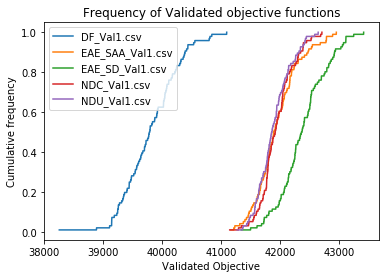

In [96]:
for file_path in compare_dt:
    data = pd.read_csv(file_path, sep='\n',header=None)
    num_bins = int(np.max(data) - np.min(data))
    counts, bin_edges = np.histogram(data, bins=num_bins, normed=True)
    cdf = np.cumsum(counts)
    plt.plot(bin_edges[1:], cdf / cdf[-1], label=file_path.split('/')[-1])
plt.title("Frequency of Validated objective functions")
plt.xlabel("Validated Objective")
plt.ylabel("Cumulative frequency")
plt.legend()
fig_name = ''
for i in range(compare_dt_nb):
    fig_name =  fig_name + '_' + model_types[i]
fig_name = 'cdf' + fig_name + '.png'
cur = os.getcwd() 
os.chdir(Path(project_folder/'Val_output_across_run'))
plt.savefig(fig_name)

The process is summarized in this figure:

![guidance](https://github.com/USC3DLAB/learning-based-optimization/blob/master/supporting/guidance.png)